<a href="https://colab.research.google.com/github/M0STAFA-MO/M0STAFA-MO/blob/main/sal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***important libraries:)***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns


from sklearn.svm import SVC
from sklearn import tree
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import svm
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
lab=LabelEncoder()
from sklearn.cluster import KMeans

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# ***Exploring the dataset:)***

In [ ]:
sal=pd.read_csv('/content/salaries.csv')
sal.sample(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
2511,2022,MI,FT,Data Analyst,100000,USD,100000,US,0,US,M
2724,2022,SE,FT,Data Scientist,129300,USD,129300,US,0,US,M
1321,2023,SE,FT,Machine Learning Engineer,163800,USD,163800,US,0,US,M
2540,2022,SE,FT,Data Engineer,132000,USD,132000,CA,0,CA,M
293,2023,EN,FT,Data Engineer,35000,GBP,42660,GB,100,GB,M


In [ ]:
!pip install pycountry
import pycountry

country_dict = {}
for country in pycountry.countries:
    country_dict[country.alpha_2] = country.name


sal['remote_ratio'] = sal['remote_ratio'].apply(lambda x: 'Fully Remote' if x==100 else ('Partially Remote' if x==50 else 'On-site'))
sal['experience_level'] = sal['experience_level'].replace({'EN':'Entry', 'MI':'Mid', 'SE':'Senior', 'EX':'Executive'})
sal['employment_type'] = sal['employment_type'].replace({'FT':'Full Time', 'PT':'Part Time', 'CT':'Contract', 'FL':'Freelance'})
sal['employee_residence'] = sal['employee_residence'].apply(lambda x:country_dict .get(x, 'Unknown or unspecified country'))
sal['company_location'] = sal['company_location'].apply(lambda x: country_dict.get(x, 'Unknown or unspecified country'))
sal['company_size'] = sal['company_size'].replace({'S': 'Small', 'M': 'Medium', 'L': 'Large'})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 37.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=9abf4ece394be92c3a402dc1ea79d2087cd044b8ac7ff08928f706f756395d2a
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built pycountry


In [ ]:
sal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4134 entries, 0 to 4133
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           4134 non-null   int64 
 1   experience_level    4134 non-null   object
 2   employment_type     4134 non-null   object
 3   job_title           4134 non-null   object
 4   salary              4134 non-null   int64 
 5   salary_currency     4134 non-null   object
 6   salary_in_usd       4134 non-null   int64 
 7   employee_residence  4134 non-null   object
 8   remote_ratio        4134 non-null   object
 9   company_location    4134 non-null   object
 10  company_size        4134 non-null   object
dtypes: int64(3), object(8)
memory usage: 355.4+ KB


In [ ]:
nu = sal.isnull().sum()
print('NUMBER OF NULL FOR EVERY COLUMN \n', nu[nu > 0])
print("----------------------------")
dub = sal.duplicated().sum()
print('NUMBER OF DUPLICATES FOR EVERY COLUMN \n', dub[dub > 0])
print("----------------------------")


NUMBER OF NULL FOR EVERY COLUMN 
 Series([], dtype: int64)
----------------------------
NUMBER OF DUPLICATES FOR EVERY COLUMN 
 [1333]
----------------------------


In [ ]:
sal.drop_duplicates(inplace=True)
sal.drop('salary', axis=1, inplace=True)


In [ ]:
#@title Default title text

import plotly.graph_objects as go
meano = sal[['experience_level', 'salary_in_usd']].groupby(['experience_level'], as_index=True).mean().sort_values(by='experience_level', ascending=False)
counts = sal['experience_level'].value_counts().sort_index()
meano['counts'] = counts.values

fig1 = go.Figure(data=[go.Bar(x=meano.index, y=meano['salary_in_usd'])])
fig1.add_trace(go.Scatter(x=meano.index, y=meano['counts'], yaxis='y2', name='Job Count'))

fig1.update_layout(title='Mean Salary and Job Count by Experience Level',
                   xaxis_title='Experience Level',
                   yaxis_title='Mean Salary (USD)',
                   yaxis2=dict(title='Job Count', overlaying='y', side='right'))

fig1.show()

In [ ]:
#@title Default title text
mean_ = sal[['company_size', 'salary_in_usd']].groupby(['company_size'], as_index=True).mean().sort_values(by='company_size', ascending=True)
counts = sal['company_size'].value_counts().sort_index()
mean_['counts'] = counts.values

fig2 = go.Figure([go.Bar(x=mean_.index, y=mean_['salary_in_usd'])])
fig2.add_trace(go.Scatter(x=mean_.index, y=mean_['counts'], yaxis='y2', name='Job Count'))

fig2.update_layout(title='Mean Salary and Job Count by Company Size',
                   xaxis_title='Company Size',
                   yaxis_title='Mean Salary (USD)',
                   yaxis2=dict(title='Job Count', overlaying='y', side='right'))

fig2.show()

In [ ]:
#@title Default title text


job_salary = sal.groupby('job_title')['salary_in_usd'].mean().head(10)

fig4 = go.Figure(data=[go.Bar(x=job_salary.index, y=job_salary.values)])

fig4.update_layout(title='Mean Salary by Job Title',
                   xaxis_title='Job Title',
                   yaxis_title='Mean Salary (USD)')

fig4.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
obj =sal.select_dtypes(include=['object']).columns
sal[obj] = sal[obj].apply(encoder.fit_transform)

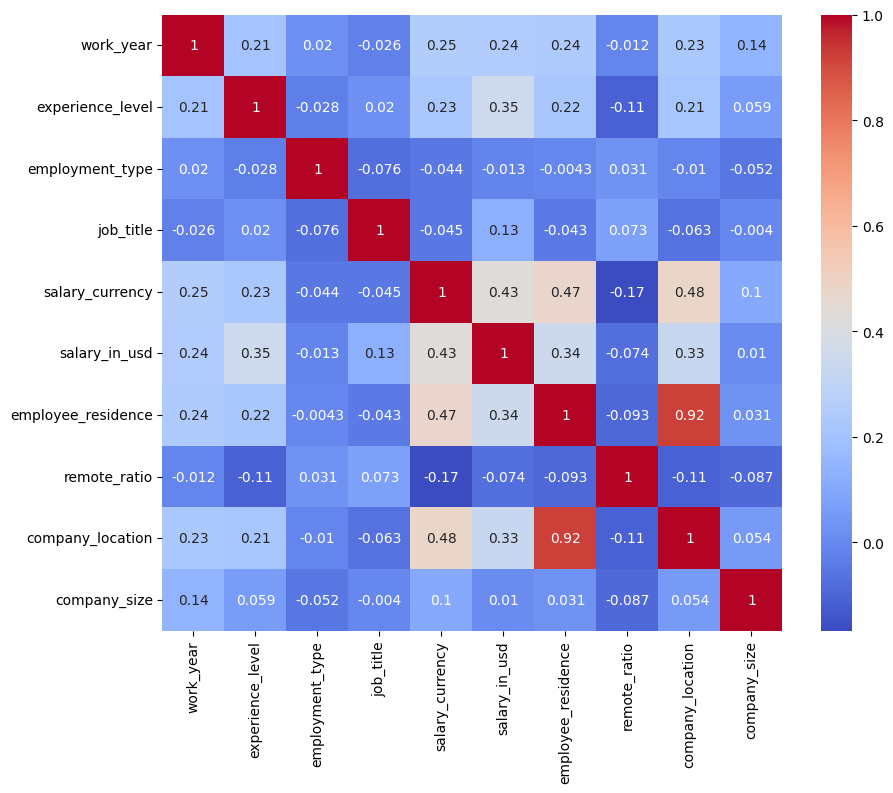

In [ ]:
#@title Default title text

plt.figure(figsize=(10, 8))
sns.heatmap(sal.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

x = sal.drop('company_size',axis=1)
y = sal['company_size']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)


print("Shape of X_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test=sc.transform(x_test)

Shape of X_train: (1960, 9)
Shape of y_train: (1960,)
Shape of X_test: (841, 9)
Shape of y_test: (841,)


In [ ]:


# Define the parameter grids for each model
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_dt = {'max_depth': [1, 2, 3, 4, 5]}
param_grid_rf = {'n_estimators': [10, 50, 100, 150, 200], 'max_depth': [1, 2, 3, 4, 5]}
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9]}
param_grid_svc = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear']}
param_grid_xgb = {'n_estimators': [10, 50, 100, 150, 200], 'max_depth': [1, 2, 3, 4, 5]}


# Create the grid search objects for each model
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5)
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_search_svc = GridSearchCV(SVC(), param_grid_svc, cv=5)
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid_xgb, cv=5)

# Fit the grid search objects to the data
grid_search_lr.fit(x_train, y_train)
grid_search_dt.fit(x_train, y_train)
grid_search_rf.fit(x_train, y_train)
grid_search_knn.fit(x_train, y_train)
grid_search_svc.fit(x_train, y_train)
grid_search_xgb.fit(x_train, y_train)

# Print the best parameters and scores for each model
print("Logistic Regression - best parameters:", grid_search_lr.best_params_)
print("Logistic Regression - best score:", grid_search_lr.best_score_)
print("Decision Tree - best parameters:", grid_search_dt.best_params_)
print("Decision Tree - best score:", grid_search_dt.best_score_)
print("Random Forest - best parameters:", grid_search_rf.best_params_)
print("Random Forest - best score:", grid_search_rf.best_score_)
print("K-Nearest Neighbors - best parameters:", grid_search_knn.best_params_)
print("K-Nearest Neighbors - best score:", grid_search_knn.best_score_)
print("Support Vector Machine - best parameters:", grid_search_svc.best_params_)
print("Support Vector Machine - best score:", grid_search_svc.best_score_)
print("_xgb - best parameters :", grid_search_xgb.best_params_)

print("_xgb - best score:", grid_search_xgb.best_score_)



Logistic Regression - best parameters: {'C': 1}
Logistic Regression - best score: 0.8204081632653061
Decision Tree - best parameters: {'max_depth': 3}
Decision Tree - best score: 0.8326530612244898
Random Forest - best parameters: {'max_depth': 5, 'n_estimators': 200}
Random Forest - best score: 0.8326530612244898
K-Nearest Neighbors - best parameters: {'n_neighbors': 9}
K-Nearest Neighbors - best score: 0.8285714285714286
Support Vector Machine - best parameters: {'C': 100, 'kernel': 'linear'}
Support Vector Machine - best score: 0.8137755102040817
_xgb - best parameters : {'max_depth': 3, 'n_estimators': 50}
_xgb - best score: 0.8331632653061224


In [ ]:
models = [ LogisticRegression(C= 1, random_state=42),
           DecisionTreeClassifier(max_depth= 5, random_state=42),
           RandomForestClassifier(max_depth= 5, n_estimators = 50, random_state=42),
           KNeighborsClassifier(n_neighbors=5),
           SVC(C=  100, kernel='linear', random_state=42),
           XGBClassifier(max_depth = 3, n_estimators= 50, random_state=42)]
results = []

for model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)


    labels = np.unique(y_test)  # Get the unique labels from y_test
    model_name = type(model).__name__
    results.append([model_name, accuracy, labels])

df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Labels'])
df = df.sort_values(by=['Accuracy'], ascending=False)
df.to_excel('model_results.xlsx', index=False)

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(
        x=df['Model'], y=df['Accuracy'],
        text=df['Accuracy'].apply(lambda x: f"{round(x,2)}"),
        textposition='auto',
        offsetgroup=1,
        name='accuracy'
    )
])

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    title="Accuracy of Different Models",
    xaxis_title="Model",
    yaxis_title="Accuracy",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#3f3f3f"
    )
)

fig.show()

In [ ]:
models = [ LogisticRegression(C=  1, random_state=42),
           DecisionTreeClassifier(max_depth= 3, random_state=42),
           RandomForestClassifier(max_depth= 5, n_estimators = 200, random_state=42),
           KNeighborsClassifier(n_neighbors=9),
           SVC(C= 100, kernel='linear', random_state=42),
           XGBClassifier(max_depth = 3, n_estimators= 50, random_state=42)]
results = []

for model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)


    model_name = type(model).__name__
    results.append([model_name, accuracy])
results


[['LogisticRegression', 0.8109393579072532],
 ['DecisionTreeClassifier', 0.8240190249702735],
 ['RandomForestClassifier', 0.8370986920332937],
 ['KNeighborsClassifier', 0.8204518430439952],
 ['SVC', 0.8145065398335315],
 ['XGBClassifier', 0.8299643281807372]]